In [34]:
%run nbloader.py

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import pylab as plt
import root_numpy
import pandas as pd
import math
from sklearn.cluster import DBSCAN

from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
%load_ext Cython


BRICK_X = 124000
BRICK_Y = 99000
BRICK_Z = 75000
SAFE_M = 10000

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [35]:
from sklearn.model_selection import train_test_split

In [36]:
from sklearn.svm import SVC
import pandas as pd

from read_opera_bg import load_bg;
from read_opera_mc import load_mc;
pbg = load_bg(step=1);
pmc = load_mc(step=1);
pbg = pbg.drop('s.eChi2', axis = 1)
pbg['signal'] = 0

bg: 27322110 tracks
numtracks reduction by cuts:  [18724, 18678, 11058, 5389, 2799, 2684]


In [38]:
def centralize_shower(shower):
    x_diff = shower['ele_x'] - 50000
    y_diff = shower['ele_y'] - 40000
    shower.loc['BT_X'] = shower.loc['BT_X'] - x_diff
    shower.loc['BT_Y'] = shower.loc['BT_Y'] - y_diff
    return shower

In [73]:
def plot_pairs(d0, d1, df):
    dZ = 205

    # mind the order!
    d00 = pd.DataFrame([
                df['s.eZ'][:],
                df['s.eX'][:],
                df['s.eY'][:]],
                index=['z', 'x', 'y']).T
    numtracks = d00.shape[0]
    dd = pd.DataFrame([
            df['s.eTX'][:]*dZ,
            df['s.eTY'][:]*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d11 = d00 + dd

    C = plt.cm.Blues(0.5)
    lc = Line3DCollection(zip(d00.values, d11.values), colors=C, alpha=0.5, lw=2)
    numtracks = len(d0[:, 0])
    

    C = plt.cm.Reds(0.5)
    lb = Line3DCollection(zip(d0[:, [2, 0, 1]], d1[:, [2, 0, 1]]), colors=C, alpha=0.9, lw=2)

    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-103, elev=16)
    ax.add_collection3d(lc)
    ax.add_collection3d(lb)

    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")
    ax.set_xlim(d0[:, 2].min(), d0[:, 2].max())
    ax.set_ylim(d0[:, 0].min(), d0[:, 0].max())
    ax.set_zlim(d0[:, 1].min(), d0[:, 1].max())

In [104]:
def format_shower(shower):
    shower_frame = pd.DataFrame([
            shower['BT_X'],
            shower['BT_Y'],
            shower['BT_Z'] - shower['BT_Z'] % 1293,
            shower['BT_SX'],
            shower['BT_SY']],
            index=['s.eX', 's.eY', 's.eZ', 's.eTX', 's.eTY']).T
    shower_frame['signal'] = 1
    
    return shower_frame

In [483]:
def generate_training_sample_signal(pmc, ip_threshold = 0.001):
    parents = list()
    sons = list()
    
    for i in range(len(pmc)):        
        numpy_frame = np.asarray(format_shower(pmc.iloc[i]))
        z_coordinates = list(set(numpy_frame[:, 2]))
        z_coordinates.sort()

        for i in range(len(z_coordinates) - 1):
            for track in numpy_frame[numpy_frame[:, 2] == z_coordinates[i] ,:]:
                next_layer = numpy_frame[numpy_frame[:, 2] == z_coordinates[i + 1] ,:]
                if (len(next_layer) != 0):
                    IP = compute_features(np.repeat(np.array([track]), len(next_layer), 0), next_layer)[:, 2]
                    if (IP.min() < ip_threshold):
                        parents.append(track)
                        sons.append(next_layer[IP.argmin(), :])

    sons = np.asarray(sons)
    parents = np.asarray(parents)
    
    signal_part = compute_features(sons, parents)
    signal_part = np.insert(signal_part, len(signal_part[0, :]), 1, axis = 1)
    
    return signal_part

def generate_training_sample_noise(pbg, box = 10000, iterations = 40):
    
    noise_sons = list()
    noise_parents = list()
    
    for i in range(iterations):
        number = np.random.randint(len(pbg))
        track = pbg.iloc[number, :]
        track = np.asarray(track)
        layer = pbg[pbg['s.eZ'] == track[2] + 1293]
        next_layer = np.asarray(layer)
        bool_index = (abs(next_layer[:, 0] - track[0]) < box) & (abs(next_layer[:, 1] - track[1]) < box)
        next_layer = next_layer[bool_index]
        noise_sons.extend([track] * len(next_layer))

        noise_parents.append(next_layer)

    noise_sons = np.asarray(noise_sons)
    noise_parents = np.concatenate(noise_parents)
    
    noise_part = compute_features(noise_sons, noise_parents)
    noise_part = np.insert(noise_part, len(noise_part[0, :]), 0, axis = 1)
    
    return noise_part

In [484]:
def prepare_for_testing(shower, noise_data):
    shower = centralize_shower(shower.copy())
    shower_frame = format_shower(shower)
    
    z_coordinates = list(set(noise_data['s.eZ']))
    z_coordinates.sort()
    z_coordinates = z_coordinates[-10:]

    shower_frame = shower_frame[shower_frame['s.eZ'].isin(z_coordinates)]
    index=['s.eX', 's.eY', 's.eZ', 's.eTX', 's.eTY', 'signal']

    
    testing_data = pd.concat([shower_frame, noise_data[noise_data['s.eZ'].isin(z_coordinates)]])
    testing_data = testing_data[index]
    
    return testing_data

def test_estimator(clf, test_data, thres = 0.9, number_of_iterations = 1):
    columns = ['s.eX', 's.eY', 's.eZ', 's.eTX', 's.eTY', 'signal']
    cleared_data = shower_finder(test_data, number_of_iterations = 1, classifier = clf, box_size = 1000, threshold = thres)
    cleared_data = pd.DataFrame(cleared_data, columns = columns)
    
    return cleared_data

def precision_recall(cleared_data, original_shower_size):
    tp = np.sum(cleared_data.signal == 1) + 0.
    fp = np.sum(cleared_data.signal == 0)
    precision = tp / (tp + fp)
    recall = tp / original_shower_size
    return [precision, recall]

In [485]:
%%cython
import numpy as np
dZ = 205

def compute_features(sons, parents):
    distance = np.sqrt(np.sum((parents - sons)[:, 0:3]**2, axis = 1))
    tan_angle = np.tan(np.arccos(1/(np.sqrt(np.sum((sons - parents)[:, 3:5]**2, axis = 1) + 1))))
    
    track_begin = sons[:, 0:3]

    track_end = np.copy(track_begin)
    track_end[:, 0] += dZ * sons[:, 3]
    track_end[:, 1] += dZ * sons[:, 4]
    track_end[:, 2] += dZ
    track_diff = track_end - track_begin
    angle_z_son = (dZ ** 2)/(np.linalg.norm(track_diff, axis = 1) * dZ)
    
    
    track_diff_par = np.transpose(np.asarray([dZ * parents[:, 3], dZ * parents[:, 4]]))
    track_diff_par = np.insert(track_diff_par, 2, dZ, axis = 1)
    
    
    IP_1 = np.linalg.norm(np.cross(parents[:, 0:3] - track_end, parents[:, 0:3] - track_begin), axis = 1)/np.linalg.norm(track_diff, axis = 1)
    IP_2 = np.linalg.norm(np.cross(track_end - parents[:, 0:3], track_end - parents[:, 0:3] - track_diff_par), axis = 1)/np.linalg.norm(track_diff_par, axis = 1)

    angle_z_parents = (dZ ** 2)/(np.linalg.norm(track_diff_par, axis = 1) * dZ)
    return np.transpose(np.asarray([distance/dZ, tan_angle, IP_1/dZ, IP_2/dZ ,angle_z_son, angle_z_parents]))


def find_similar(track, next_layer, classifier, threshold, box_size):
    
    track = np.array(track, dtype = float)
    indexes = np.arange(len(next_layer))
    
    bool_index = (abs(next_layer[:, 0] - track[0]) < box_size) & (abs(next_layer[:, 1] - track[1]) < box_size)
    next_layer = next_layer[bool_index]
    indexes = indexes[bool_index]
    
    if len(next_layer) == 0:
        return np.array([])
    dist = classifier.predict_proba(compute_features(np.repeat(np.array([track]), len(next_layer), 0), next_layer))[:, 1]
    result = dist > threshold
    
    return indexes[result]

In [486]:
def clear_layer(to_clear, to_compare, classifier, threshold, box_size):
    if (len(to_clear) == 0):
        return to_clear
    final_result = np.ndarray((len(to_clear,)),dtype=np.object)
    for i in xrange(len(to_clear)):
        result = find_similar(to_clear[i], to_compare, classifier, threshold, box_size)
        final_result[i] = result
                            
    f = np.vectorize(len)
    index = f(final_result) > 0
    
    to_clear = to_clear[index, :]
    if len(to_clear) == 0:
        return to_clear
    result = np.unique(np.hstack(final_result[index]))
    
    to_compare = to_compare[result]
    return np.concatenate([to_clear, to_compare])

def shower_finder(data, classifier, number_of_iterations = 1, threshold = 0.98, box_size = 3000):
    layers = list(set(data[:, 2]))
    layers.sort()
    for n in range(number_of_iterations):
        for i in range(len(layers) - 1):
            cleared_data = clear_layer(data[data[:, 2] == layers[i]], data[data[:, 2] == layers[i+1]], classifier, threshold, box_size)
            data = data[(data[:, 2] != layers[i]) & (data[:, 2] != layers[i+1])]
            data = np.concatenate([data, cleared_data])
    return data


In [175]:
np.random.seed(42)
train_pbg, test_pbg = train_test_split(pbg, test_size = 0.5)
train_pmc, test_pmc = train_test_split(pmc, test_size = 0.5)

### Чтобы сгенировать тренировочный набор для сигнала, нужно понять по какой границе IP мы будем объединять треки в ливни. Ниже пример такого объедениния, где в пары объединяются треки у которых IP < 0.4.

In [105]:
parents = list()
sons = list()

for i in range(1):
    numpy_frame = np.asarray(format_shower(pmc.iloc[i]))
    z_coordinates = list(set(numpy_frame[:, 2]))
    z_coordinates.sort()

    for i in range(len(z_coordinates) - 1):
        for track in numpy_frame[numpy_frame[:, 2] == z_coordinates[i] ,:]:
            next_layer = numpy_frame[numpy_frame[:, 2] == z_coordinates[i + 1] ,:]
            if (len(next_layer) != 0):
                IP = compute_features(np.repeat(np.array([track]), len(next_layer), 0), next_layer)[:, 2]
                if (IP.min() < 0.4):
                    parents.append(track)
                    sons.append(next_layer[IP.argmin(), :])

sons = np.asarray(sons)
parents = np.asarray(parents)

signal_part = compute_features(sons, parents)
signal_part = np.insert(signal_part, len(signal_part[0, :]), 1, axis = 1)
plot_pairs(sons, parents, format_shower(pmc.iloc[0]))

## Сгенерируем обучающую выборку.

In [304]:
np.random.seed(42)
signal_train_sample = generate_training_sample_signal(train_pmc[:100], ip_threshold=0.4)

In [305]:
np.random.seed(42)
noise_train_sample = generate_training_sample_noise(train_pbg[:500000])

In [306]:
len(noise_train_sample)

39420

In [307]:
len(signal_train_sample)

35218

In [308]:
df = np.random.permutation(np.concatenate([noise_train_sample, signal_train_sample]))

In [309]:
len(df)

74638

In [310]:
svm = SVC(C = 10, probability = True)
svm.fit(df[:, :6], df[:, 6])

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [311]:
from sklearn.externals import joblib

In [324]:
svm_strange = joblib.load('svm/svm1.pkl')

In [489]:
test_data = prepare_for_testing(test_pmc.iloc[0], test_pbg[:600000])

In [314]:
len(test_data)

104448

In [490]:
cleared_data = test_estimator(svm_strange, np.array(test_data), thres=0.5, number_of_iterations=1)

In [491]:
print 'Original shower size: ' + str(np.sum(test_data.signal == 1))
print 'Cleared shower size: ' + str(np.sum(cleared_data.signal == 1))
print
print 'Original noise size: ' + str(np.sum(test_data.signal == 0))
print 'Cleared noise size: ' + str(np.sum(cleared_data.signal == 0))

Original shower size: 308
Cleared shower size: 108

Original noise size: 104140
Cleared noise size: 1176


## Построим Precision / Recall

In [336]:
test_data = prepare_for_testing(test_pmc.iloc[0], test_pbg[:600000])

precision = []
recall = []
for thres in np.linspace(0.3, 0.9, num=10):
    cleared_data = test_estimator(svm_strange, np.array(test_data), thres=thres)
    point = precision_recall(cleared_data, np.sum(np.array(test_data)[:,5] == 1))
    precision.append(point[0])
    recall.append(point[1])

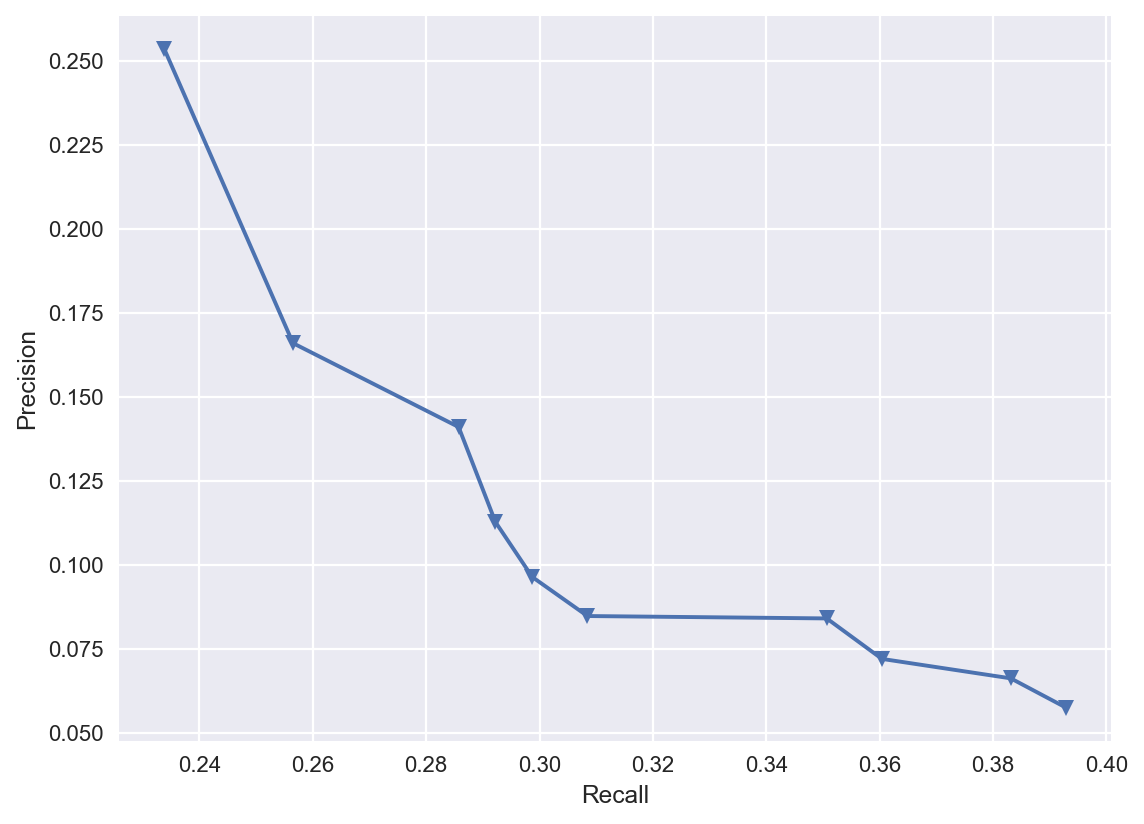

In [337]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize = (8,6), dpi = 80)
plt.plot(recall, precision, '-v')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show();

### Отсутпление: распределение фичей.

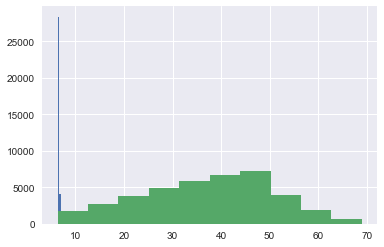

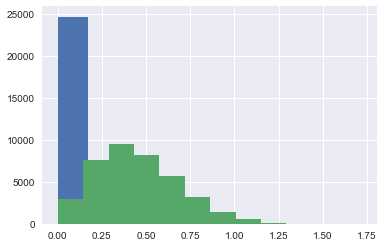

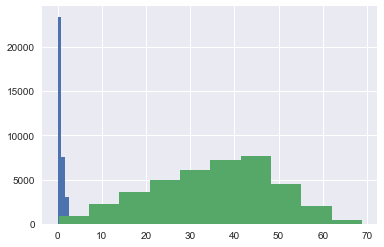

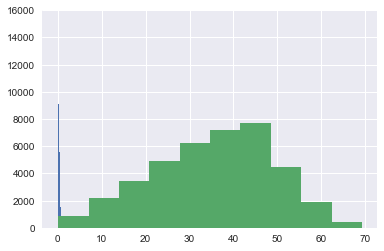

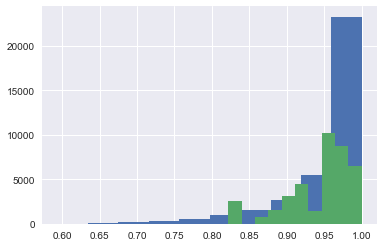

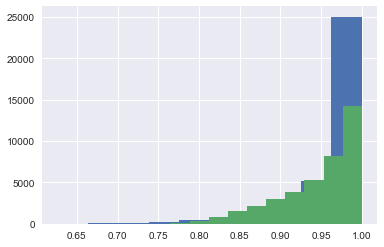

In [322]:
%matplotlib inline
plt.hist(df[:, 0][df[:, 6] == 1]);
plt.hist(df[:, 0][df[:, 6] == 0]);
plt.show()
plt.hist(df[:, 1][df[:, 6] == 1]);
plt.hist(df[:, 1][df[:, 6] == 0]);
plt.show()
plt.hist(df[:, 2][df[:, 6] == 1]);
plt.hist(df[:, 2][df[:, 6] == 0]);
plt.show()
plt.hist(df[:, 3][df[:, 6] == 1]);
plt.hist(df[:, 3][df[:, 6] == 0]);
plt.show()
plt.hist(df[:, 4][df[:, 6] == 1]);
plt.hist(df[:, 4][df[:, 6] == 0]);
plt.show()
plt.hist(df[:, 5][df[:, 6] == 1]);
plt.hist(df[:, 5][df[:, 6] == 0]);
plt.show()

## Теперь добавим алгоритмы на графах для последующей обработки данных.

In [404]:
def find_similar_old(track, next_layer, classifier, threshold, box_size):
    
    track = np.array(track, dtype = float)
    indexes = np.arange(len(next_layer))
    
    bool_index = (abs(next_layer[:, 0] - track[0]) < box_size) & (abs(next_layer[:, 1] - track[1]) < box_size)
    next_layer = next_layer[bool_index]
    indexes = indexes[bool_index]
    if len(next_layer) == 0:
        return -1
    dist = classifier.predict_proba(compute_features(np.repeat(np.array([track]), len(next_layer), 0), next_layer))[:, 1]
    result = dist.argmax()
    if dist[result] > threshold:
        return indexes[result]
    return -1

In [419]:
def compute_sequence(current_sequence, cleared_data, classifier):
    current_z = current_sequence[-1][2]
    next_layer = cleared_data[cleared_data[:, 2] == current_z + 1293]
    result = find_similar_old(current_sequence[-1], next_layer, classifier=classifier, threshold=0.8, box_size=1000)
    if result == -1:
        return current_sequence
    else:
        return compute_sequence(current_sequence + [next_layer[result]], cleared_data, classifier)

In [420]:
def produce_sequences(cleared_data, classifier):
    z_coordinates = list(set(cleared_data[:,2]))
    z_coordinates.sort()
    
    result = []
    for track in cleared_data[cleared_data[:, 2] == z_coordinates[0]]:
        result.append(compute_sequence([track], cleared_data, classifier))
    
    return result

In [543]:
def prepare_signal_sequences(pmc, classifier):
    sequences = []
    for i in range(len(pmc)):
        shower_frame = format_shower(pmc.iloc[i])
        shower_frame = shower_frame[shower_frame['s.eZ'] > 60000]
        numpy_frame = np.asarray(shower_frame)
        
        if len(numpy_frame) == 0:
            continue
        
        result = produce_sequences(numpy_frame, classifier)
        if result == None:
            continue
        sequences += result
        
    return sequences
        

In [522]:
def prepare_training_set(sequences):
    X_train = []
    y_train = []
    for i in range(len(sequences)):
        seq_feature = []
        seq = sequences[i]
        for index in range(len(seq) - 1):
            features = compute_features(np.array([seq[index]]), np.array([seq[index + 1]])).reshape(6)
            seq_feature.append(features)
        X_train.append(np.array(seq_feature))
        y_train.append(np.array([seq[0][5]] * (len(seq) - 1), dtype = int))
        
    return np.array(X_train), np.array(y_train)

## Прогоним данные через SVM, чтобы получить последовательности. После этого обучимся на них.

In [532]:
test_data = prepare_for_testing(test_pmc.iloc[0], train_pbg[:3000000])
cleared_data = test_estimator(svm_strange, np.array(test_data), thres=0.5, number_of_iterations=1)

In [534]:
sequences = produce_sequences(np.asarray(cleared_data), classifier = svm)

In [538]:
len(sequences)

20421

In [544]:
training_signal_sequences = prepare_signal_sequences(train_pmc[:500], classifier=svm)

In [545]:
len(training_signal_sequences)

8938

In [546]:
sequences_train = training_signal_sequences + sequences

In [547]:
long_sequences = filter(lambda x: len(x) > 2, sequences_train)

In [548]:
X_train, y_train = prepare_training_set(long_sequences)

In [528]:
from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM

In [551]:
model = ChainCRF()
ssvm = FrankWolfeSSVM(model=model, C=50, max_iter=20)
ssvm.fit(X_train, y_train) 

FrankWolfeSSVM(C=50, batch_mode=False, check_dual_every=10, do_averaging=True,
        line_search=True, logger=None, max_iter=20,
        model=ChainCRF(n_states: 2, inference_method: max-product),
        n_jobs=1, random_state=None, sample_method='perm',
        show_loss_every=0, tol=0.001, verbose=0)

# Протестируем итоговый алгоритм.

In [552]:
test_data = prepare_for_testing(test_pmc.iloc[0], test_pbg[:3000000])
cleared_data = test_estimator(svm_strange, np.array(test_data), thres=0.5, number_of_iterations=1)

In [553]:
print 'Original shower size: ' + str(np.sum(test_data.signal == 1))
print 'Cleared shower size: ' + str(np.sum(cleared_data.signal == 1))
print
print 'Original noise size: ' + str(np.sum(test_data.signal == 0))
print 'Cleared noise size: ' + str(np.sum(cleared_data.signal == 0))

Original shower size: 308
Cleared shower size: 135

Original noise size: 520142
Cleared noise size: 35267


In [554]:
sequences = produce_sequences(np.asarray(cleared_data), classifier = svm)

In [556]:
X_test, y_test = prepare_training_set(filter(lambda x: len(x) > 2, sequences))

In [558]:
y_predict = ssvm.predict(X_test)

In [570]:
from itertools import compress
cleared_sequences = list(compress(sequences, map(lambda x: x[0] == 1 ,y_predict)))

In [574]:
cleared_sequences = np.concatenate(cleared_sequences)

In [578]:
print 'Original shower size: ' + str(np.sum(test_data.signal == 1))
print 'Cleared shower size: ' + str(np.sum(cleared_sequences[:, 5] == 1))
print
print 'Original noise size: ' + str(np.sum(test_data.signal == 0))
print 'Cleared noise size: ' + str(np.sum(cleared_sequences[:, 5] == 0))

Original shower size: 308
Cleared shower size: 47

Original noise size: 520142
Cleared noise size: 1194


In [584]:
import read_opera_bg
columns = ['s.eX', 's.eY', 's.eZ', 's.eTX', 's.eTY', 'signal']

len(slopes): 1241


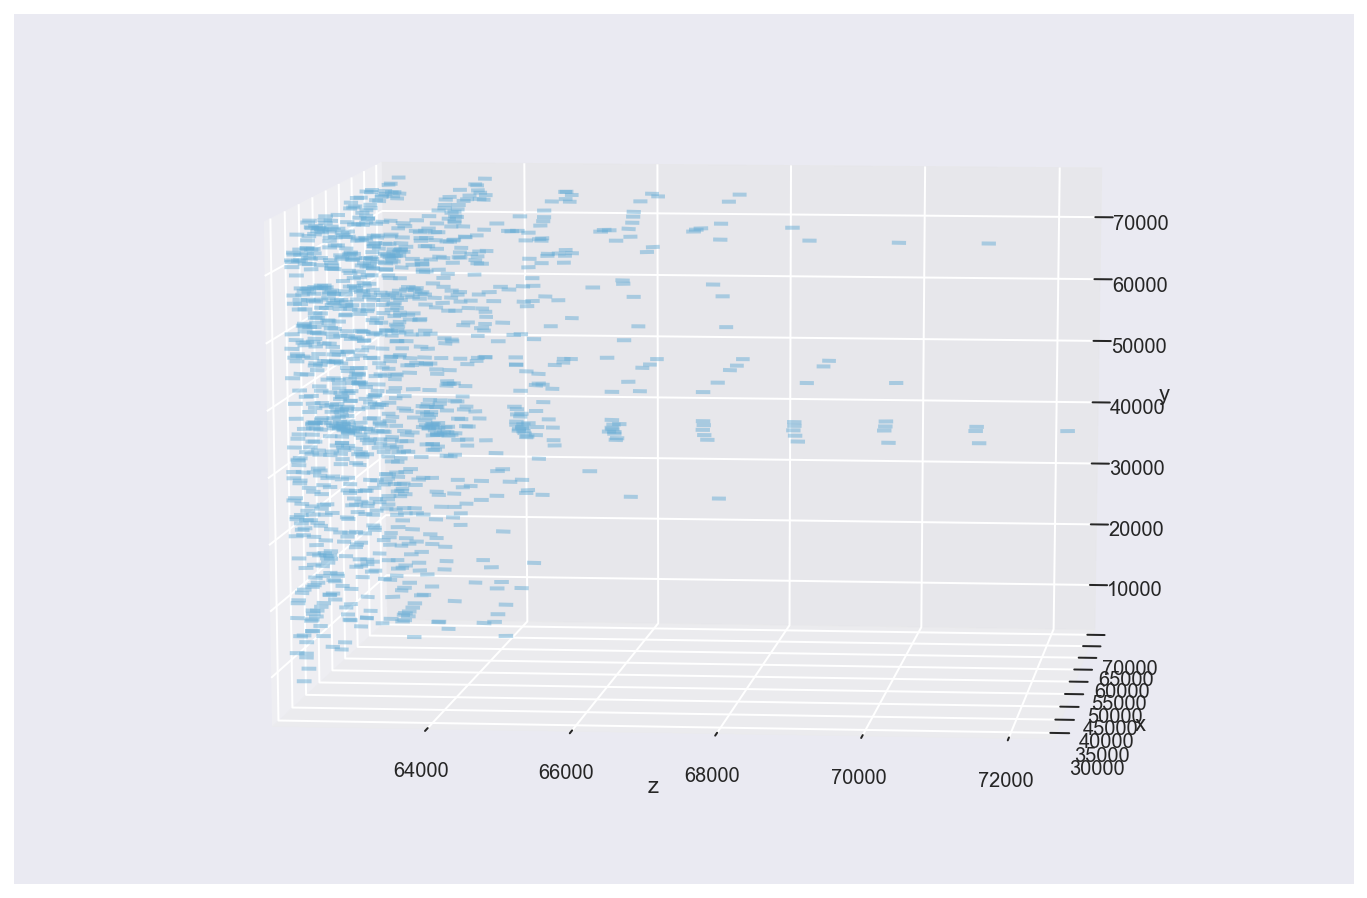

In [585]:
read_opera_bg.plot_bg(pd.DataFrame(cleared_sequences, columns = columns))